In [53]:
import re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import FreqDist

from kneed import KneeLocator
from wordcloud import WordCloud

In [54]:
with open("headlines.csv", 'r') as f:
    text = f.readlines()
print(text[:7])

['"Budget to set scene for election\n', ' \n', " Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Ã‚Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n", ' \n', ' Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Ã‚Â£2bn to spare.\n', ' \n', ' - Increase in the stamp duty threshold from Ã‚Â£60,000 \n']


In [55]:
df = pd.read_csv("headlines.csv", header=None)
df.head()

,0
0,Budget to set scene for election\n \n Gordon B...
1,Army chiefs in regiments decision\n \n Militar...
2,Howard denies split over ID cards\n \n Michael...
3,Observers to monitor UK election\n \n Minister...
4,Kilroy names election seat target\n \n Ex-chat...


### Data Preprocessing

In [56]:
swords = stopwords.words('english')
wnl = WordNetLemmatizer()

In [57]:
swords.extend(["said", "make", "new", "one", "say", "would", "also"])

In [58]:
def lemmatize(word):
    tag = pos_tag([word])
    pos = 'n'
    if tag[0][1].startswith('N'):
        pos = 'n'
    if tag[0][1].startswith('V'):
        pos = 'v'
    if tag[0][1].startswith('J'):
        pos = 'a'
    if tag[0][1].startswith('R'):
        pos = 'r'
    return wnl.lemmatize(word, pos=pos)

In [59]:
def clean_text(sent):
    tokens1 = word_tokenize(sent)
    tokens2 = [token for token in tokens1 if token.isalpha()]
    tokens3 = [token.lower() for token in tokens2 if token.lower() not in swords]
    tokens4 = [lemmatize(token) for token in tokens3]
    return tokens4

In [60]:
sent = 'It was expected to rain today. But not completely determined.'
clean_text(sent)

['expect', 'rain', 'today', 'completely', 'determine']

In [61]:
cleaned_text = df[0].apply(clean_text)

In [62]:
cleaned_text

0       [budget, set, scene, election, gordon, brown, ...
1       [army, chief, regiment, decision, military, ch...
2       [howard, denies, split, id, card, michael, how...
3       [observer, monitor, uk, election, minister, in...
4       [kilroy, name, election, seat, target, show, h...
                              ...                        
2220    [india, open, sky, competition, india, allow, ...
2221    [yukos, bankruptcy, u, matter, russian, author...
2222    [survey, confirms, property, slowdown, governm...
2223    [high, fuel, price, hit, ba, profit, british, ...
2224    [u, trade, gap, hit, record, gap, u, export, i...
Name: 0, Length: 2225, dtype: object

In [63]:
final_text = ' '.join(cleaned_text.sum())
final_text

'budget set scene election gordon brown seek put economy centre labour bid third term power delivers ninth budget gmt expect stress importance continued economic stability low unemployment interest rate chancellor expect freeze petrol duty raise stamp duty threshold conservative lib dems insist voter face high tax labour treasury official giveaway mr brown thought spare increase stamp duty threshold freeze petrol duty extension tax credit scheme poorer family possible help pensioner stamp duty threshold rise intend help first time buyer likely theme three main party general election manifesto ten year ago buyer much great chance avoid stamp duty close half million property england wale alone sell less since average uk property price double start threshold stamp duty increase tax credit result number property incur stamp duty rocket government tax take liberal democrat unveiled proposal raise stamp duty threshold february tory thought likely propose increase threshold shadow chancellor 

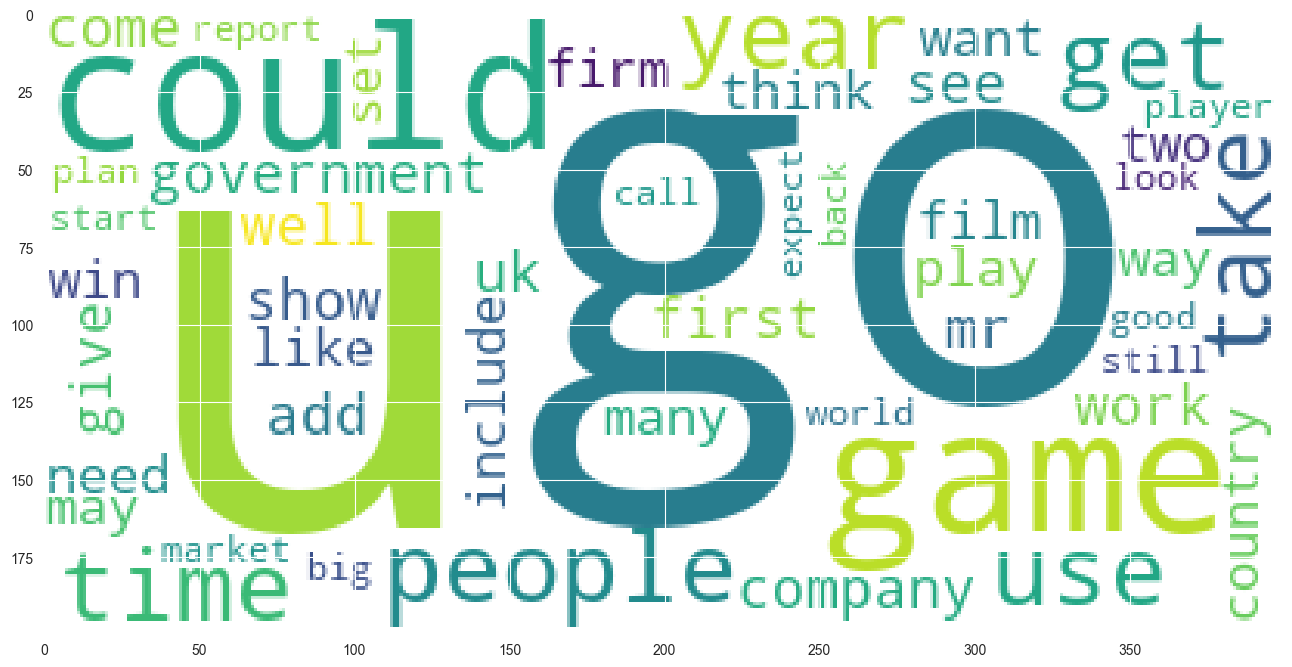

In [64]:
wc = WordCloud(stopwords=swords, background_color='white', max_words=50).generate(final_text)
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.show()

### Vectorization

In [65]:
tfidf = TfidfVectorizer(analyzer=clean_text)
x_new = tfidf.fit_transform(df[0])
x_new.shape

(2225, 21404)

### Create Clusters

In [66]:
sse = []
for k in range(1, 16):
    km = KMeans(k, random_state=0, n_init='auto')
    km.fit_predict(x_new)
    sse.append(km.inertia_)

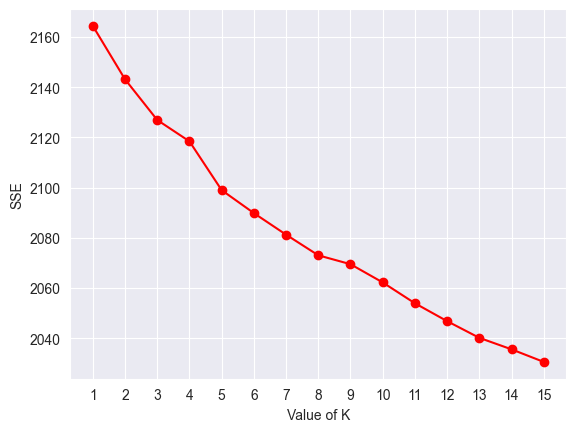

In [67]:
plt.xlabel("Value of K")
plt.ylabel("SSE")
plt.grid(True)
plt.xticks(range(1, 16))
plt.plot(range(1, 16), sse, marker='o', color='red')
plt.show()

### Identify clusters

In [68]:
kl = KneeLocator(range(1, 16), sse, curve='convex', direction='decreasing')
kl.elbow

np.int64(5)

### Final

In [69]:
km = KMeans(n_clusters=5, random_state=0, n_init='auto')

In [70]:
labels = km.fit_predict(x_new)
labels

array([4, 3, 4, ..., 3, 3, 3], shape=(2225,), dtype=int32)

In [71]:
km.labels_

array([4, 3, 4, ..., 3, 3, 3], shape=(2225,), dtype=int32)

### Visualize

In [72]:
copydf = cleaned_text.copy().to_frame()
copydf["Cluster"] = km.labels_

In [73]:
copydf

,0,Cluster
0,"[budget, set, scene, election, gordon, brown, ...",4
1,"[army, chief, regiment, decision, military, ch...",3
2,"[howard, denies, split, id, card, michael, how...",4
3,"[observer, monitor, uk, election, minister, in...",4
4,"[kilroy, name, election, seat, target, show, h...",4
...,...,...
2220,"[india, open, sky, competition, india, allow, ...",3
2221,"[yukos, bankruptcy, u, matter, russian, author...",3
2222,"[survey, confirms, property, slowdown, governm...",3
2223,"[high, fuel, price, hit, ba, profit, british, ...",3


In [74]:
cluster1 = copydf[copydf["Cluster"] == 0]
cluster2 = copydf[copydf["Cluster"] == 1]
cluster3 = copydf[copydf["Cluster"] == 2]
cluster4 = copydf[copydf["Cluster"] == 3]
cluster5 = copydf[copydf["Cluster"] == 4]

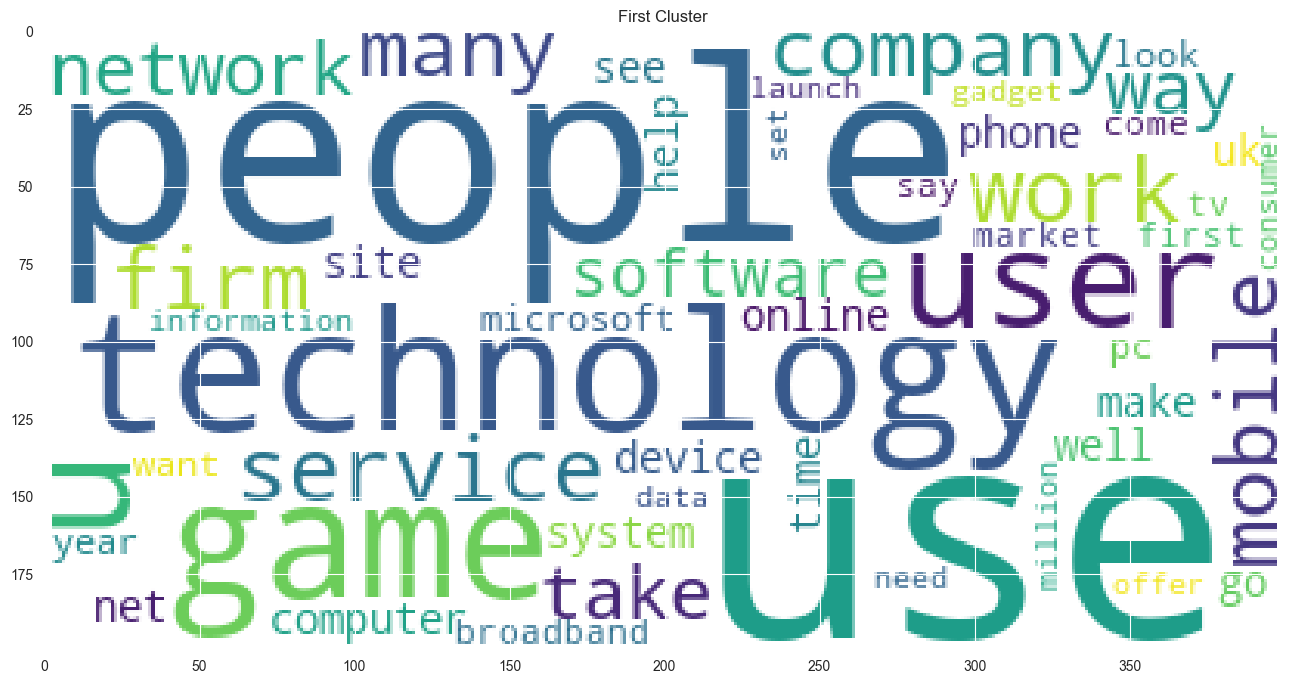

In [75]:
wc = WordCloud(background_color='white', max_words=50).generate(' '.join(cluster1[0].sum()))
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.title("First Cluster")
plt.show()

In [76]:
freq = FreqDist(cluster1[0].sum())
freq.most_common(10)

[('people', 952),
 ('use', 876),
 ('game', 807),
 ('technology', 602),
 ('mobile', 596),
 ('phone', 552),
 ('service', 525),
 ('mr', 482),
 ('get', 468),
 ('user', 461)]

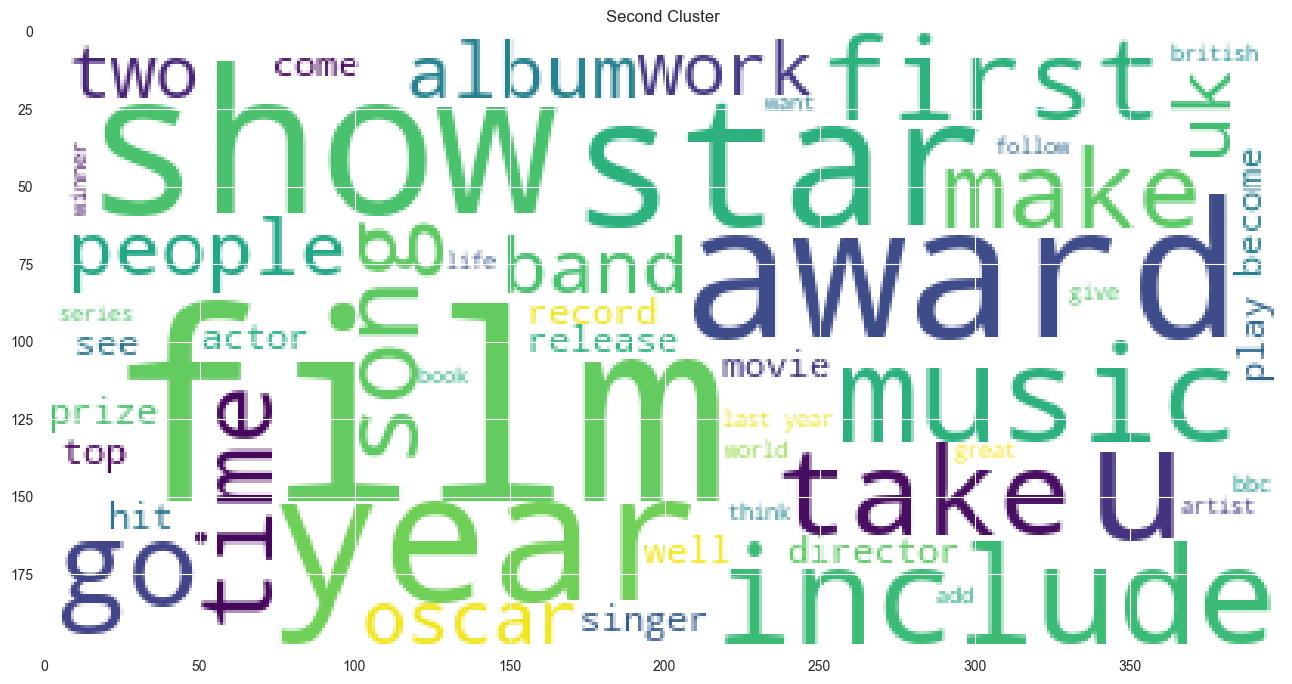

In [77]:
wc = WordCloud(background_color='white', max_words=50).generate(' '.join(cluster2[0].sum()))
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.title("Second Cluster")
plt.show()

In [78]:
freq = FreqDist(cluster2[0].sum())
freq.most_common(10)

[('film', 1004),
 ('best', 606),
 ('year', 568),
 ('award', 564),
 ('star', 436),
 ('show', 433),
 ('music', 376),
 ('u', 326),
 ('include', 320),
 ('take', 307)]

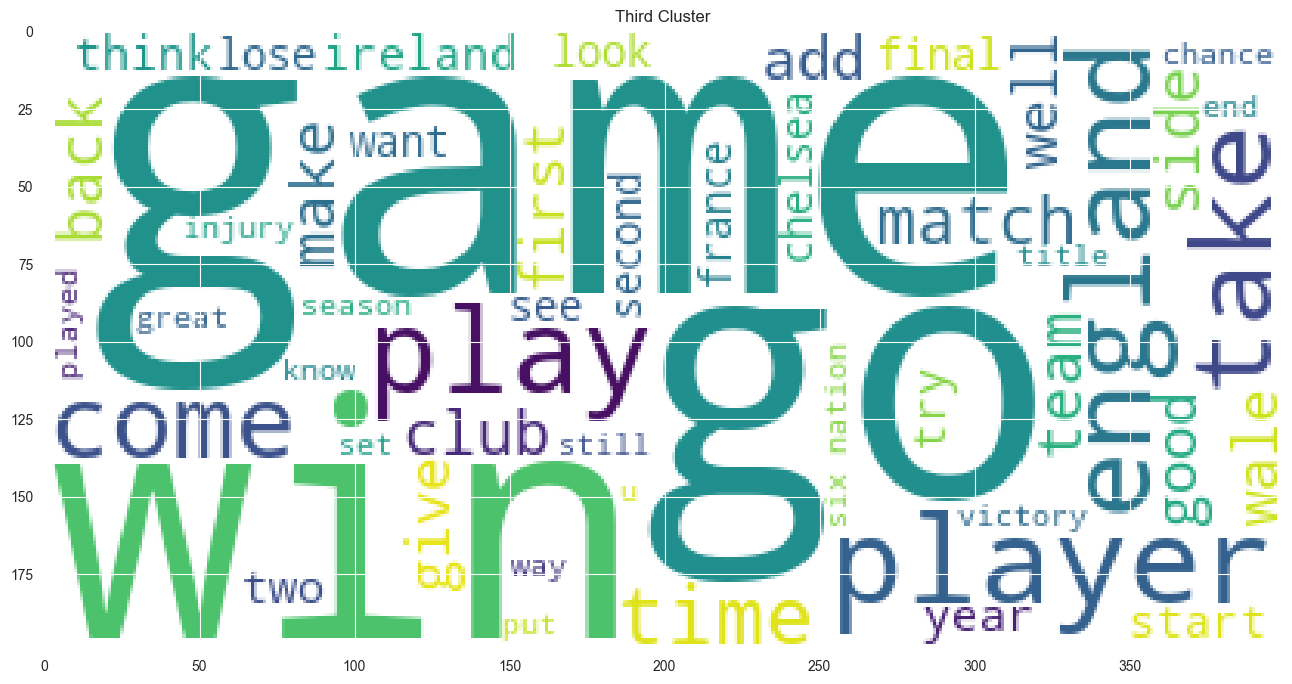

In [79]:
wc = WordCloud(background_color='white', max_words=50).generate(' '.join(cluster3[0].sum()))
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.title("Third Cluster")
plt.show()

In [80]:
freq = FreqDist(cluster3[0].sum())
freq.most_common(10)

[('game', 709),
 ('win', 589),
 ('go', 527),
 ('player', 493),
 ('take', 475),
 ('get', 470),
 ('play', 467),
 ('england', 463),
 ('year', 450),
 ('first', 443)]

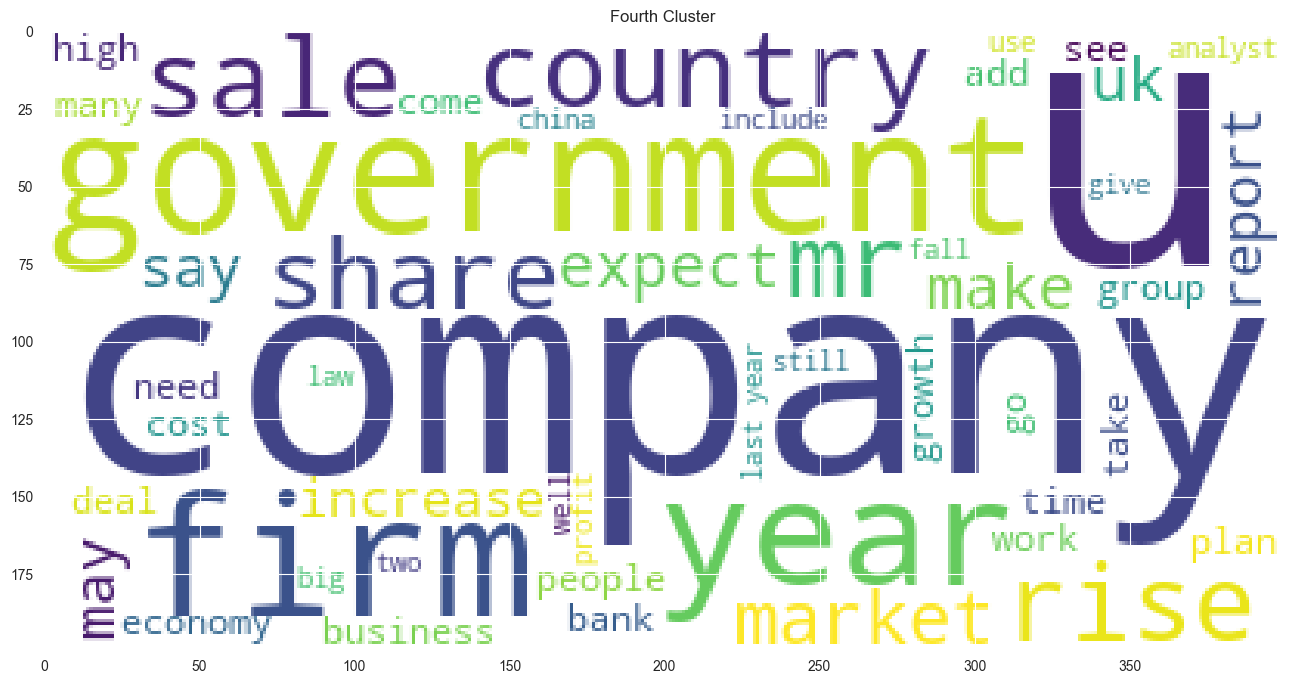

In [81]:
wc = WordCloud(background_color='white', max_words=50).generate(' '.join(cluster4[0].sum()))
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.title("Fourth Cluster")
plt.show()

In [82]:
freq = FreqDist(cluster4[0].sum())
freq.most_common(10)

[('year', 1109),
 ('u', 951),
 ('mr', 846),
 ('company', 681),
 ('firm', 579),
 ('government', 574),
 ('market', 534),
 ('last', 460),
 ('could', 457),
 ('sale', 453)]

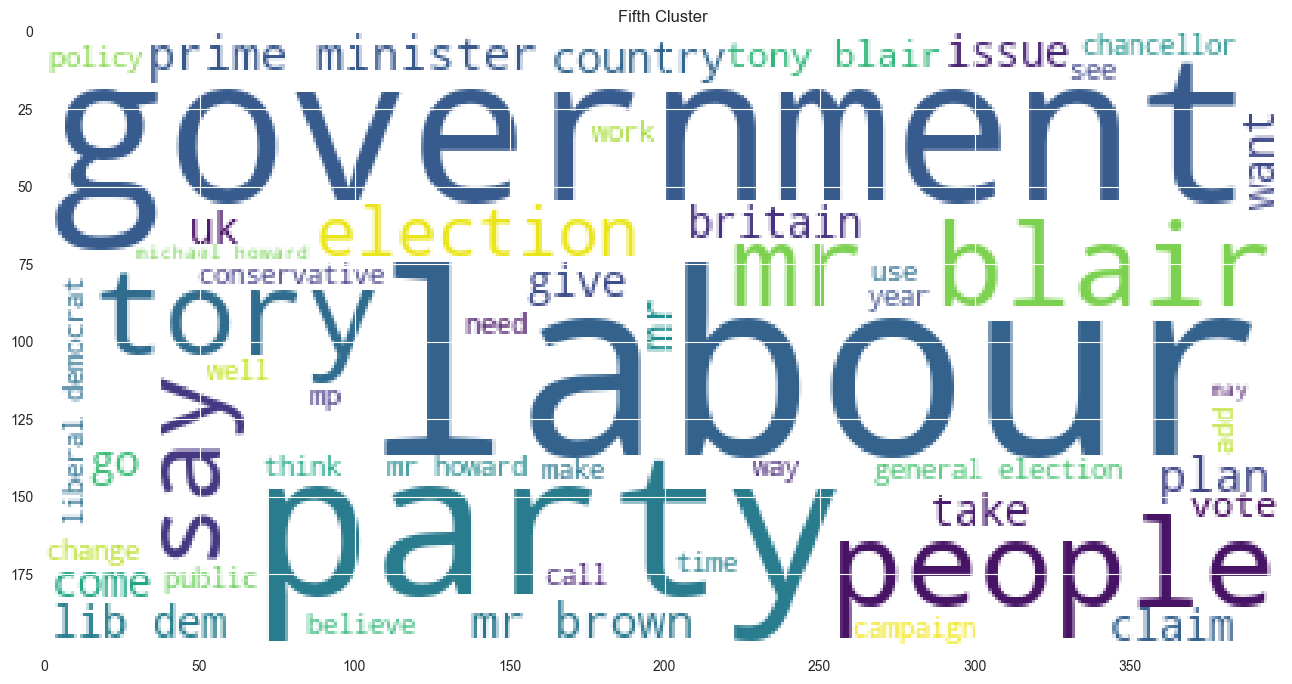

In [83]:
wc = WordCloud(background_color='white', max_words=50).generate(' '.join(cluster5[0].sum()))
plt.figure(figsize=(16, 9))
plt.imshow(wc)
plt.title("Fifth Cluster")
plt.show()

In [84]:
freq = FreqDist(cluster5[0].sum())
freq.most_common(10)

[('mr', 1511),
 ('labour', 731),
 ('party', 675),
 ('election', 626),
 ('blair', 545),
 ('government', 530),
 ('tory', 485),
 ('people', 445),
 ('minister', 417),
 ('brown', 375)]

In [97]:
news = '''The Shakespeare drama starring Paul Mescal and Jessie Buckley has a stellar cast but is "exploitative" and lacks subtlety – "it tugs the heartstrings and targets the tear ducts with absolute ruthlessness".

There's no doubt that, in many people's eyes, Hamnet will be one of the films of the year. Swept along on a wave of adoring reviews, it's sure to land on dozens of "best of 2025" lists, and on thousands of Oscar ballots. None of this is all that surprising.

The film is adapted from Maggie O'Farrell's poetic novel, which is one of the most acclaimed bestsellers of the 21st Century. The other key figure behind the camera is the director and co-writer, Chloé Zhao (O'Farrell herself is the other co-writer), who made the Oscar-winning Nomadland. In front of the camera, the film boasts two of Ireland's most magnetic young actors, Jessie Buckley and Paul Mescal. And there is another creative genius involved: William Shakespeare. The conceit of the novel and the film is that the tragic death of Shakespeare's 11-year-old son – the titular Hamnet – fed into the writing of the greatest play in the English language, Hamlet. In Elizabethan England, an opening caption informs us, the names Hamnet and Hamlet were interchangeable.

But does Hamnet live up to the promise of its stellar personnel? That is the question. It's true that many viewers have already fallen under its spell, but Zhao and O'Farrell have stripped away so much of what makes the novel magical – the time-travelling structure, the hypnotic prose rhythms, the internal monologues and the tiny, tangible details – that what's left is no more profound or authentic than any other costume drama set in ye olde days.
It's clear from the opening scenes that Hamnet isn't going to be a subtle film

Its early scenes aren't a million miles away from Shakespeare in Love (1998). Buckley plays a farmer's daughter named Anne Hathaway, or Agnes as she is addressed by her family, and Mescal is a glovemaker's son and jobbing Latin tutor named Will. Agnes is rumoured to be the daughter of a forest witch, a rumour which she doesn't try to dispel: she spends half of her time out in the woods with a pet hawk, picking herbs and fungi for her poultices and potions. And, just to emphasise that she is at one with nature, we're treated to a shot which has become familiar in recent years: the one in which the camera points up at the sky through a frame of rustling treetops. Will, meanwhile, is in his attic, scribbling away at a first draft of Romeo and Juliet, so it's clear from the opening scenes that Hamnet isn't going to be a subtle film.

Buckley gives a very Buckley-ish performance. Like so many of her characters, Agnes is a fierce, earthy rebel who is more honest than anyone else around her. Naturally, the nervous Will is soon smitten, and stammers, "I wish to be hand-fasted to you." It's a warm and sweet romance, but not especially believable. The newlywed Shakespeares live an idyllic, picture-postcard life with their daughter Susanna and their adorable twins, Hamnet (Jacobi Jupe) and Judith (Olivia Lynes). (One of the film's conceits is that the twins are uncannily similar, so it's a shame that the actors look nothing like each other.) Stratford-upon-Avon is weirdly short of other houses and other people. And the contrived conversations are peppered with quotes from Shakespeare's plays, and explanations of situations which everyone in the scene would already know. Will's bullying father tells him that he's useless on two separate occasions (and on the second one, Will grabs him around the chin and slams him against a wall, much like Mescal's character in Normal People did to his girlfriend's brother, only louder).
'''

In [98]:
news = tfidf.transform([news])
label = km.predict(news)
label

array([1], dtype=int32)